This section goes on to read the input data and study how they are made, check the dataset size, add the necessary labels to classify, truncate the useless columns and merge the two datasets provided. 

In [24]:
import pandas as pd

# Function to read the data from a CSV file and print some information about it
def read_data(file_path):
    print("Opening dataset:", file_path)
    df = pd.read_csv(file_path)
    print("Dataframe shape:", df.shape)
    print("Dataframe columns:", df.columns)
    print("Number of missing values in each column:\n", df.isnull().sum(), "\n")
    print("Removing duplicates in the dataset:", df.duplicated().sum(), "\n")
    df = df.drop_duplicates()
    return df

# Open CSV files
true_data = read_data("Datasets/True.csv") # True news
true_data['label'] = 1 # Add a label column to the true data

false_data = read_data("Datasets/Fake.csv") # Fake news
false_data['label'] = 0 # Add a label column to the fake data

# We actually don't need the date column for the classification
true_data.drop(columns=['date'])
false_data.drop(columns=['date'])

# Merge the two datasets
dataset = pd.concat([true_data, false_data], ignore_index=True) 

# Ignore index to reset the index
print("Dataset merged, resulting shape:", dataset.shape)

# Check if the dataset has the correct shape
assert dataset.shape[0] == true_data.shape[0] + false_data.shape[0]
assert dataset.shape[1] == true_data.shape[1] == false_data.shape[1]
assert dataset.duplicated().sum() == 0

Opening dataset: Datasets/True.csv
Dataframe shape: (21417, 4)
Dataframe columns: Index(['title', 'text', 'subject', 'date'], dtype='object')
Number of missing values in each column:
 title      0
text       0
subject    0
date       0
dtype: int64 

Removing duplicates in the dataset: 206 

Opening dataset: Datasets/Fake.csv
Dataframe shape: (23481, 4)
Dataframe columns: Index(['title', 'text', 'subject', 'date'], dtype='object')
Number of missing values in each column:
 title      0
text       0
subject    0
date       0
dtype: int64 

Removing duplicates in the dataset: 3 

Dataset merged, resulting shape: (44689, 5)


In [25]:
import string
import re
import contractions
import nltk
from nltk.corpus import stopwords

# Create a new label that has title and text
dataset['full_text'] = dataset['title'] + " " + dataset['text']

# Remove the title and text columns
dataset = dataset.drop(columns=['title', 'text', 'date', 'subject'])

# Download the stopwords from NLTK
nltk.download('stopwords')

# Inspired by : https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/
def text_cleaner(text):
    # Lowercasing the data
    text = text.lower()

    # Removing Puncuatations
    punctuations = string.punctuation
    text = ''.join([char for char in text if char not in punctuations])

    # Removing Numbers
    # Actually, we can keep the numbers as they can be useful in the classification
    # By the way, the code for remove them is:
    # text = re.sub('[0-9]+', '', text)

    # Removing extra space
    text = re.sub(' +', ' ', text)

    # Replacing the repetitions of punctations
    text = re.sub(r'([!?,.])\1+', r'\1', text)

    # Removing Emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Removing Contractions
    text = contractions.fix(text)

    # Removing URLs
    text = re.sub(r'http\S+', '', text)

    # Removing stopwords
    # We can use the stopwords from NLTK
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Clean the text
dataset['full_text'] = dataset['full_text'].apply(text_cleaner)

# Save the dataset
dataset.to_csv("Datasets/News.csv", index=False)

print("Dataset saved to 'Datasets/News.csv'")

<>:42: SyntaxWarning: invalid escape sequence '\)'
<>:42: SyntaxWarning: invalid escape sequence '\)'
C:\Users\mannu\AppData\Local\Temp\ipykernel_13664\1555872318.py:42: SyntaxWarning: invalid escape sequence '\)'
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


Dataset saved to 'Datasets/News.csv'


This section goes on to split the data into training and testing data using the according functions from sklearn. The TfidfVectorizer is then used to convert the text data into numerical data that can be used for the classification, using the fit_transform function.

In [26]:
# Test train data split and import TfidfVectorizer  to implement Bag of Words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the dataset into training and testing data
X_train,X_test,y_train,y_test=train_test_split(dataset.full_text,dataset.label,test_size=.2,random_state=1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# Initialize the TfidfVectorizer, which will convert the text data into a matrix of token counts
# We can also use CountVectorizer, but TfidfVectorizer is more efficient because it considers the frequency of the words
cv=TfidfVectorizer()

# Fitting the classifier to the training data
x_train_cv = cv.fit_transform(X_train)
x_test_cv = cv.transform(X_test)
predictions_list = [] # List to store the future predictions
classifier_name_list = [] # List to store the classifier names

X_train shape:  (35751,)
X_test shape:  (8938,)


The next few sections will use various Classifier to predict the test values that have been splitted from the dataset. They are predicted using the TfidfVectorizer that have been fitted to the training data. Then the predictions are appended to a list to be used for plotting various analysis.

In [27]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf=RandomForestClassifier()
rf.fit(x_train_cv,y_train)
y_pred_randomForest=rf.predict(x_test_cv)

predictions_list.append(y_pred_randomForest)
classifier_name_list.append("Random Forest Classifier")

In [82]:
# Using KNN Classifier for 5 neighbors
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_cv,y_train)
y_pred_knn=knn.predict(x_test_cv)

predictions_list.append(y_pred_knn)
classifier_name_list.append("KNN Classifier")

# Tuning the KNN Classifier using GridSearchCV to find the best value of k
from sklearn.model_selection import GridSearchCV

knn=KNeighborsClassifier()
param_grid = {'n_neighbors': [1,3,5,7,9]}
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(x_train_cv,y_train)
y_pred_knn_tuned=knn_gscv.predict(x_test_cv)
print("Best parameters for KNN Classifier: ", knn_gscv.best_params_)
print("Best score for KNN Classifier: ", knn_gscv.best_score_)
print("Accuracy score for all k values: ", knn_gscv.cv_results_['mean_test_score'])

Best parameters for KNN Classifier:  {'n_neighbors': 1}
Best score for KNN Classifier:  0.7336019120021358
Accuracy score for all k values:  [0.73360191 0.65922633 0.62384266 0.60317191 0.70556985]


In [29]:
# Using Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train_cv, y_train)
y_pred_log_reg = log_reg.predict(x_test_cv)

predictions_list.append(y_pred_log_reg)
classifier_name_list.append("Logistic Regression")

In [31]:
#Using Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(x_train_cv, y_train)
y_pred_mnb = mnb.predict(x_test_cv)

predictions_list.append(y_pred_mnb)
classifier_name_list.append("Multinomial Naive Bayes")

This section implements plotting and classification report for each classifier that was used in the predictions_list, which contains the predictions for each classifier using the test data set. The classification report shows the precision, recall, f1-score and support for each class. The accuracy is also shown. The confusion matrix shows the true positive, false positive, true negative and false negative values. The ROC curve shows the true positive rate against the false positive rate. The AUC (Area Under the Curve) is also shown.

Now showing results for Random Forest Classifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4635
           1       0.99      0.99      0.99      4303

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

0.9923920340120832


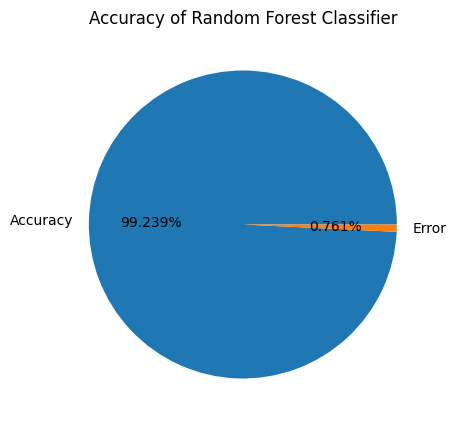

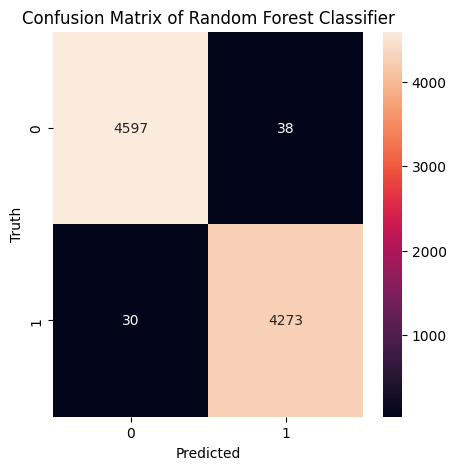

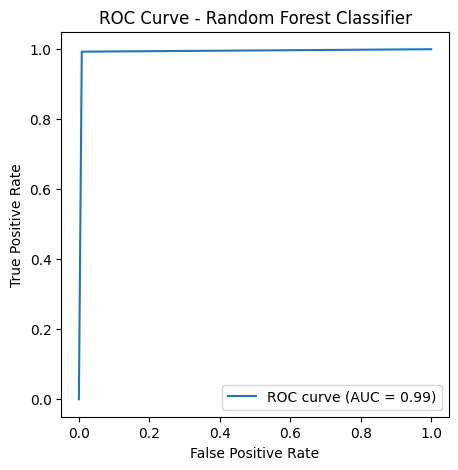

Now showing results for KNN Classifier
              precision    recall  f1-score   support

           0       0.59      0.99      0.74      4635
           1       0.97      0.24      0.39      4303

    accuracy                           0.63      8938
   macro avg       0.78      0.62      0.56      8938
weighted avg       0.77      0.63      0.57      8938

0.6320205862609085


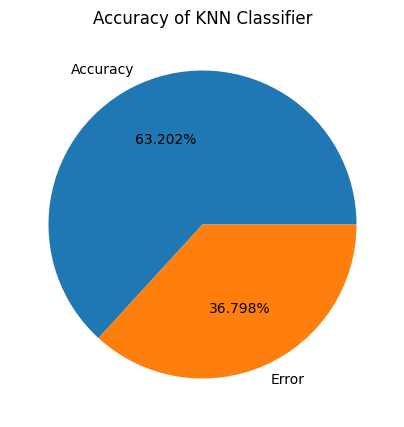

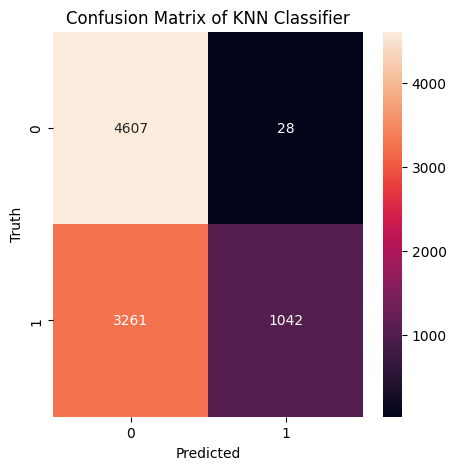

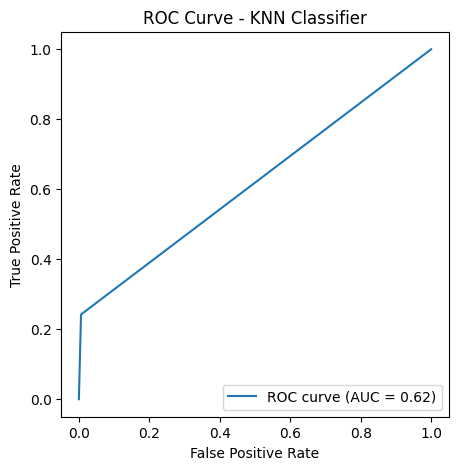

Now showing results for Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4635
           1       0.99      0.99      0.99      4303

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

0.9875811143432536


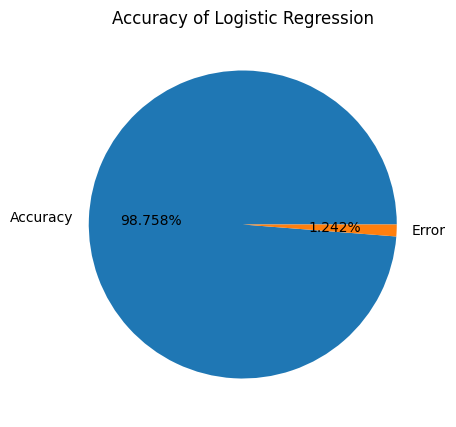

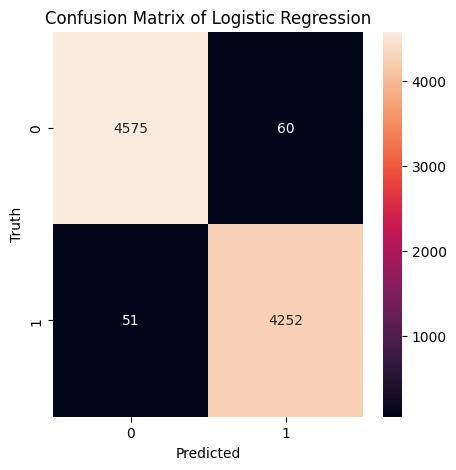

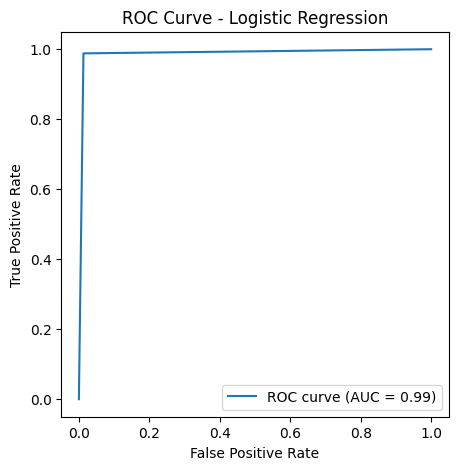

Now showing results for Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4635
           1       0.95      0.95      0.95      4303

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938

0.9486462295815619


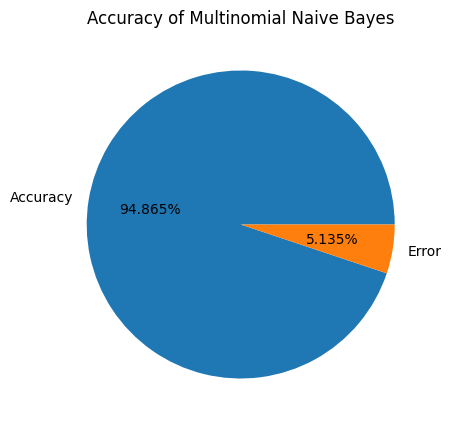

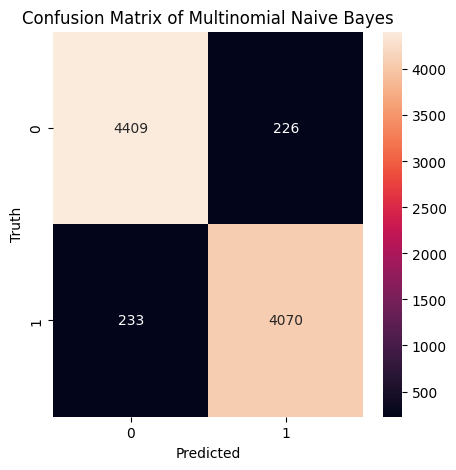

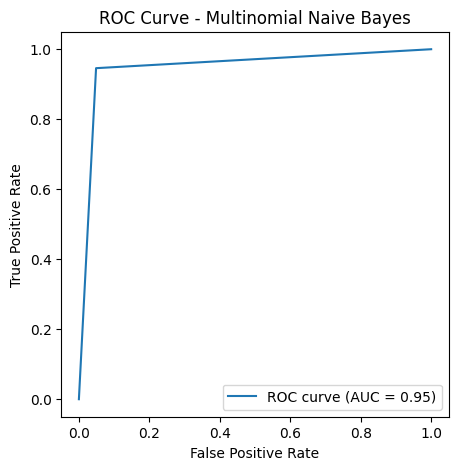

In [33]:
# Plotting the accuracy of the model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import learning_curve
import numpy as np

# Function to plot the accuracy of the model
def plot_accuracy(y_test,y_pred,classifier_name):
    print(accuracy_score(y_test,y_pred))
    plt.figure(figsize=(5,5))
    plt.title('Accuracy of ' + classifier_name)
    plt.pie([accuracy_score(y_test,y_pred),1-accuracy_score(y_test,y_pred)],labels=['Accuracy','Error'],autopct='%1.3f%%')
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_test,y_pred,classifier_name):
    plt.figure(figsize=(5,5))
    plt.title('Confusion Matrix of ' + classifier_name)
    cm=confusion_matrix(y_test,y_pred)
    sns.heatmap(cm,annot=True,fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

# Function to plot the ROC AUC curve
def plot_roc_auc_curve(y_test, y_pred, classifier_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred) # Calculate the FPR and TPR
    auc = roc_auc_score(y_test, y_pred) # Calculate the AUC
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + classifier_name)
    plt.legend(loc="lower right")
    plt.show()

# Print the classification report and plot the accuracy, 
# confusion matrix and ROC AUC curve for each classifier
for index, y_pred in enumerate(predictions_list):
    print("Now showing results for",classifier_name_list[index])
    print(classification_report(y_test, y_pred))
    plot_accuracy(y_test, y_pred,classifier_name_list[index])
    plot_confusion_matrix(y_test, y_pred,classifier_name_list[index])
    plot_roc_auc_curve(y_test, y_pred, classifier_name_list[index])

In [34]:
# Function to plot learning curves

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

for index, y_pred in enumerate(predictions_list):
    plot_learning_curve(rf, classifier_name_list[index], x_train_cv, y_train, cv=3, n_jobs=-1)
    

'\ndef plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):\n    plt.figure()\n    plt.title(title)\n    plt.xlabel("Training examples")\n    plt.ylabel("Score")\n    train_sizes, train_scores, test_scores = learning_curve(\n        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)\n    train_scores_mean = np.mean(train_scores, axis=1)\n    train_scores_std = np.std(train_scores, axis=1)\n    test_scores_mean = np.mean(test_scores, axis=1)\n    test_scores_std = np.std(test_scores, axis=1)\n    plt.grid()\n    \n    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\n                     train_scores_mean + train_scores_std, alpha=0.1,\n                     color="r")\n    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\n                     test_scores_mean + test_scores_std, alpha=0.1,\n                     color="g")\n    plt.plot(train_sizes, train_scores_mean, \'o-\', color="r", la

The news article is:  Fake
Now showing results for Random Forest Classifier
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       1.00      0.29      0.44         7

    accuracy                           0.64        14
   macro avg       0.79      0.64      0.59        14
weighted avg       0.79      0.64      0.59        14

0.6428571428571429


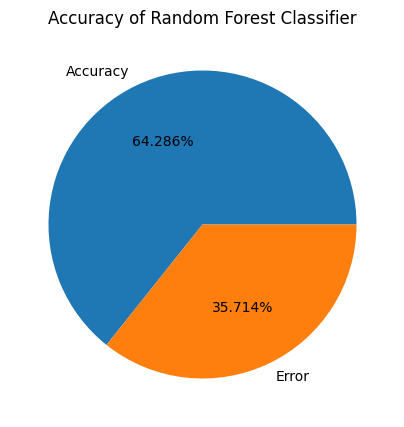

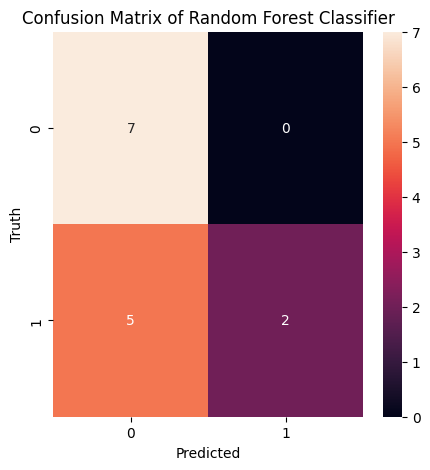

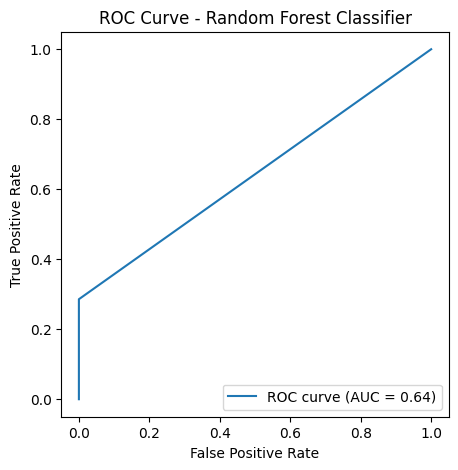

Now showing results for KNN Classifier
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       1.00      0.29      0.44         7

    accuracy                           0.64        14
   macro avg       0.79      0.64      0.59        14
weighted avg       0.79      0.64      0.59        14

0.6428571428571429


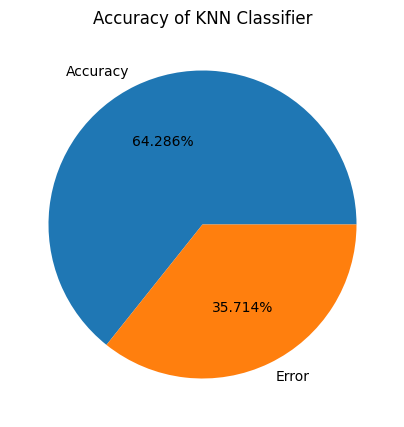

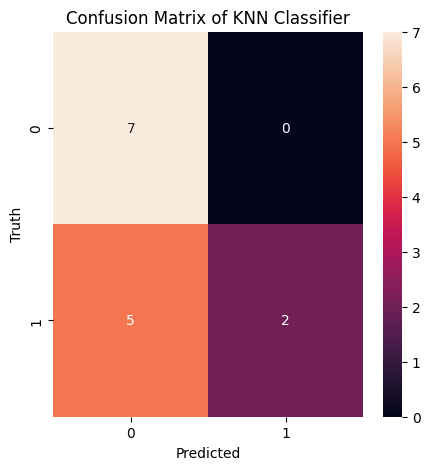

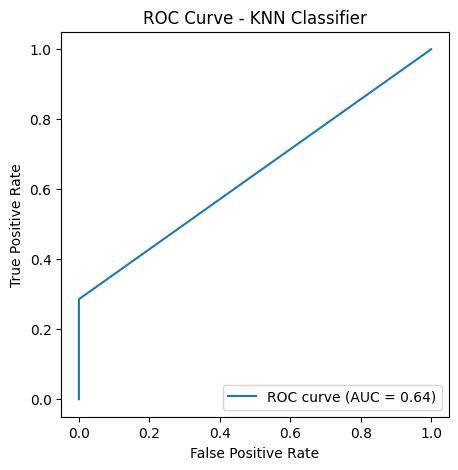

Now showing results for Logistic Regression
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       1.00      0.29      0.44         7

    accuracy                           0.64        14
   macro avg       0.79      0.64      0.59        14
weighted avg       0.79      0.64      0.59        14

0.6428571428571429


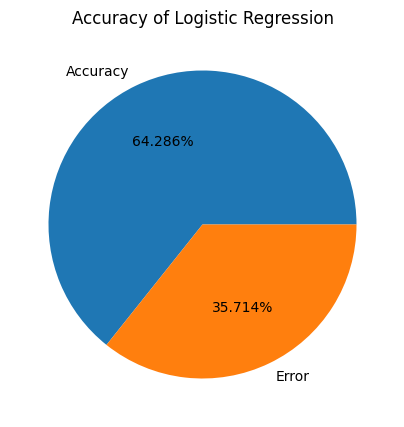

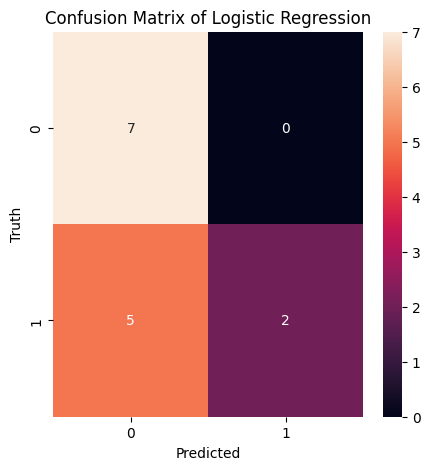

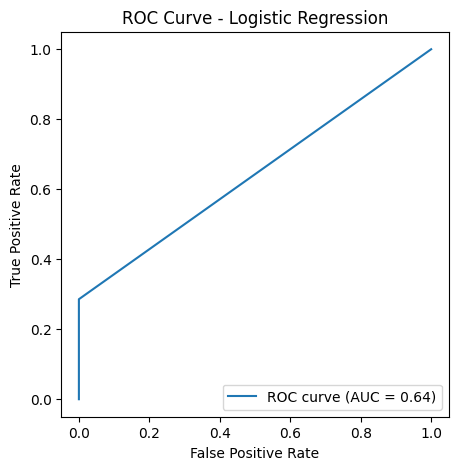

Now showing results for Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       1.00      0.29      0.44         7

    accuracy                           0.64        14
   macro avg       0.79      0.64      0.59        14
weighted avg       0.79      0.64      0.59        14

0.6428571428571429


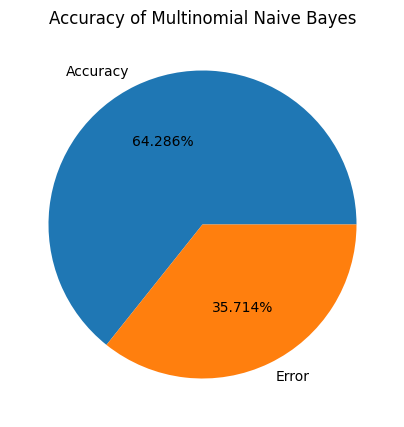

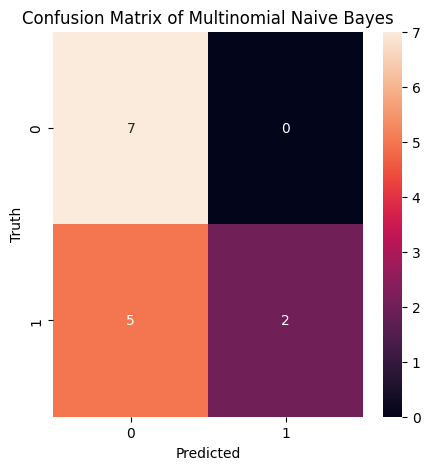

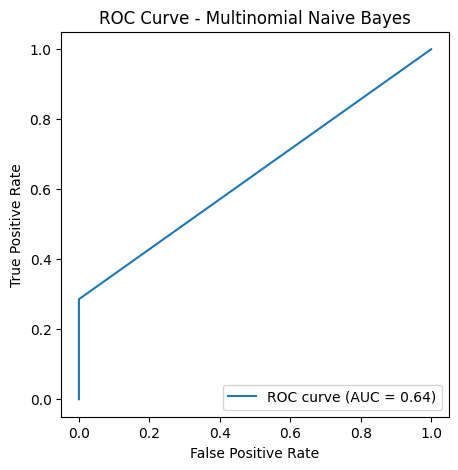

In [80]:
# Loading external articles to test the model

def load_articles(file_path):
    articles = []
    with open(file_path, 'r', encoding="utf8") as file:
        for line in file:
            articles.append(line)
    return articles

#In this dataset, the articles with an even index are true, the ones with an odd index are fake

articles = load_articles("externalArticles.cvs")

# Input a news article to test the model

def test_news_input(text, classifier):
    news_cv = cv.transform([text]) # Convert the text to a matrix of token counts
    return classifier.predict(news_cv) # Predict the label

predicted_label = test_news_input(articles[12], knn) # Test the model with an article
print("The news article is: ", "True" if predicted_label else "Fake")

#Plotting external articles accuracy, confusion matrix and ROC AUC curve
def test_and_pred_for_exteranl_articles(classifier):
    y_test = []
    y_pred = []
    for i in range(len(articles)): # Iterate over the articles
        y_test.append((i+1) % 2) # True if even, False if odd
        y_pred.append(test_news_input(articles[i], classifier)) # Predict the label
    return y_test, y_pred

# Print the classification report and plot the accuracy, 
# confusion matrix and ROC AUC curve for each classifier
for index, y_pred in enumerate(predictions_list):
    y_test, y_pred = test_and_pred_for_exteranl_articles(rf)
    print("Now showing results for",classifier_name_list[index])
    print(classification_report(y_test, y_pred))
    plot_accuracy(y_test, y_pred,classifier_name_list[index])
    plot_confusion_matrix(y_test, y_pred,classifier_name_list[index])
    plot_roc_auc_curve(y_test, y_pred, classifier_name_list[index])